This notebook was created by Donna Faith Go.

In [1]:
# standard imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# wavelet decomposition
import pywt

# additive decomposition
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

# seasonal decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

# Time Series Decomposition (TSD)

## Wavelet Decomposition

Wavelet decomposition 
- is a technique that breaks down a time series into different frequency components, providing insights into the time-varying behavior of the data at various scales.
- is useful for identifying transient or abrupt changes in the time series.
- is suitable for non-stationary data.

Note for self:
1. Maybe I can use this to look for points of financial crashes.
2. I will use discrete wavelet transform (DWT)

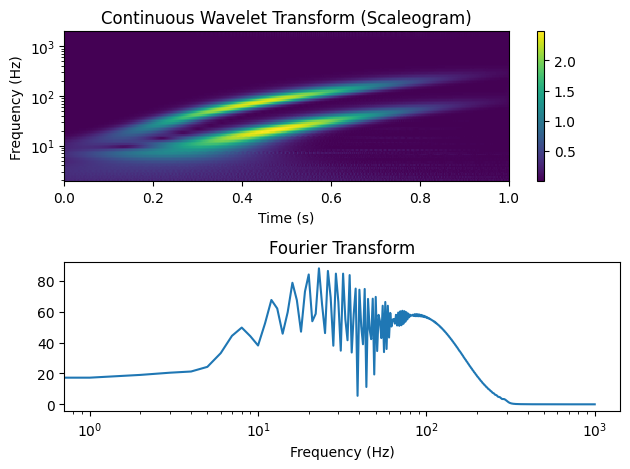

In [2]:
def gaussian(x, x0, sigma):
    return np.exp(-np.power((x - x0) / sigma, 2.0) / 2.0)

def make_chirp(t, t0, a):
    frequency = (a * (t + t0)) ** 2
    chirp = np.sin(2 * np.pi * frequency * t)
    return chirp, frequency

# generate signal
time = np.linspace(0, 1, 2000)
chirp1, frequency1 = make_chirp(time, 0.2, 9)
chirp2, frequency2 = make_chirp(time, 0.1, 5)
chirp = chirp1 + 0.6 * chirp2
chirp *= gaussian(time, 0.5, 0.2)

# perform CWT
wavelet = "cmor1.5-1.0"
# logarithmic scale for scales, as suggested by Torrence & Compo:
widths = np.geomspace(1, 1024, num=100)
sampling_period = np.diff(time).mean()
cwtmatr, freqs = pywt.cwt(chirp, widths, wavelet, sampling_period=sampling_period)
# absolute take absolute value of complex result
cwtmatr = np.abs(cwtmatr[:-1, :-1])

# plot result using matplotlib's pcolormesh (image with annoted axes)
fig, axs = plt.subplots(2, 1)
pcm = axs[0].pcolormesh(time, freqs, cwtmatr)
axs[0].set_yscale("log")
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("Frequency (Hz)")
axs[0].set_title("Continuous Wavelet Transform (Scaleogram)")
fig.colorbar(pcm, ax=axs[0])

# plot fourier transform for comparison
from numpy.fft import rfft, rfftfreq

yf = rfft(chirp)
xf = rfftfreq(len(chirp), sampling_period)
plt.semilogx(xf, np.abs(yf))
axs[1].set_xlabel("Frequency (Hz)")
axs[1].set_title("Fourier Transform")
plt.tight_layout()

## Singular Spectrum Analysis (SSA)

Singular Spectrum Analysis 
- is a technique for decomposing time series data into its main components, including trend, seasonality, and noise.
- utilizes singular value decomposition to extract meaningful signals from the data, making it particularly effective for time series forecasting and signal denoising.

Note for self:
1. Maybe I can use this to look at the general trend of a time series.

## Additive Decomposition

Additive decomposition
- breaks a time series into fixed trend, seasonal, and residual components
- it assumes constant seasonal patterns
- $Y = T + S + R$

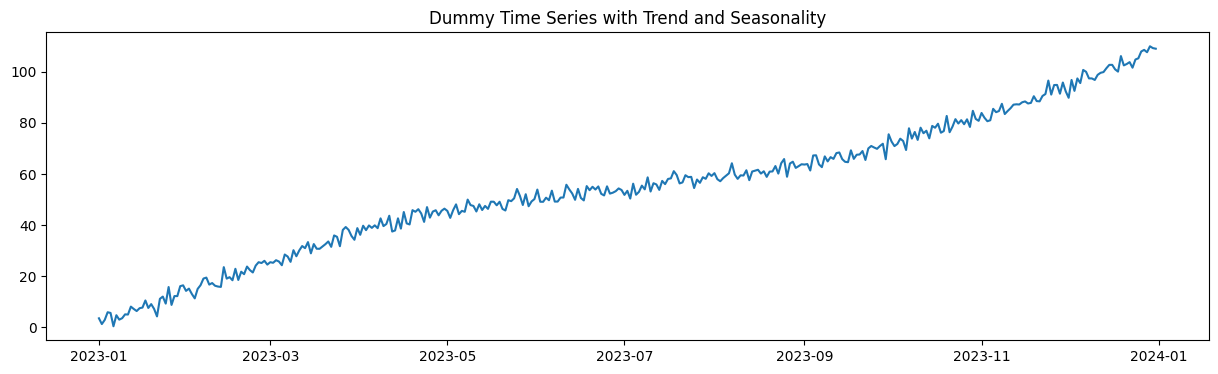

In [3]:
# dummy time series with trend, seasonality, and residual
np.random.seed(0)
date_rng = pd.date_range(start='2023/01/01', end='2023/12/31', freq='D')
t = np.arange(len(date_rng))
trend = 0.3 * t
seasonality = 10 * np.sin(2*np.pi*t/365)
residuals = np.random.normal(0, 2, len(date_rng))
ts = pd.Series(trend + seasonality + residuals, index=date_rng)

# plotting
plt.figure(figsize=(15, 4))
plt.plot(ts)
plt.title('Dummy Time Series with Trend and Seasonality')
plt.show()

### Moving Average

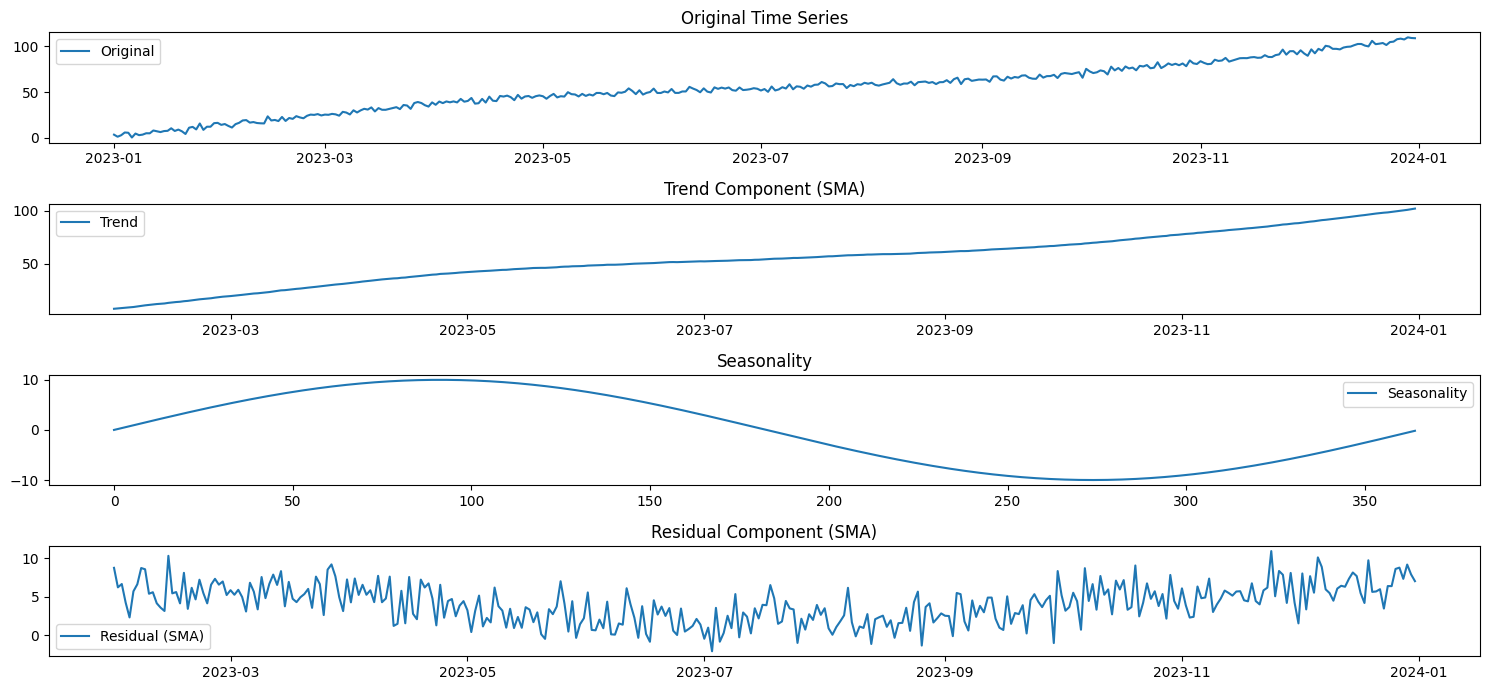

In [4]:
# additive decompsition with SMA (simple moving average)
window_size = 30
trend_sma = ts.rolling(window=window_size).mean()
residual_sma = ts - trend_sma
seasonality = 10 * np.sin(2 * np.pi * t / 365)

# plotting
plt.figure(figsize=(15, 7))
plt.subplot(4, 1, 1)
plt.plot(ts, label='Original')
plt.title('Original Time Series')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(trend_sma, label='Trend')
plt.title('Trend Component (SMA)')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(seasonality, label='Seasonality')
plt.title('Seasonality')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(residual_sma, label='Residual (SMA)')
plt.title('Residual Component (SMA)')
plt.legend()

plt.tight_layout()
plt.show()

### Exponential Smoothing

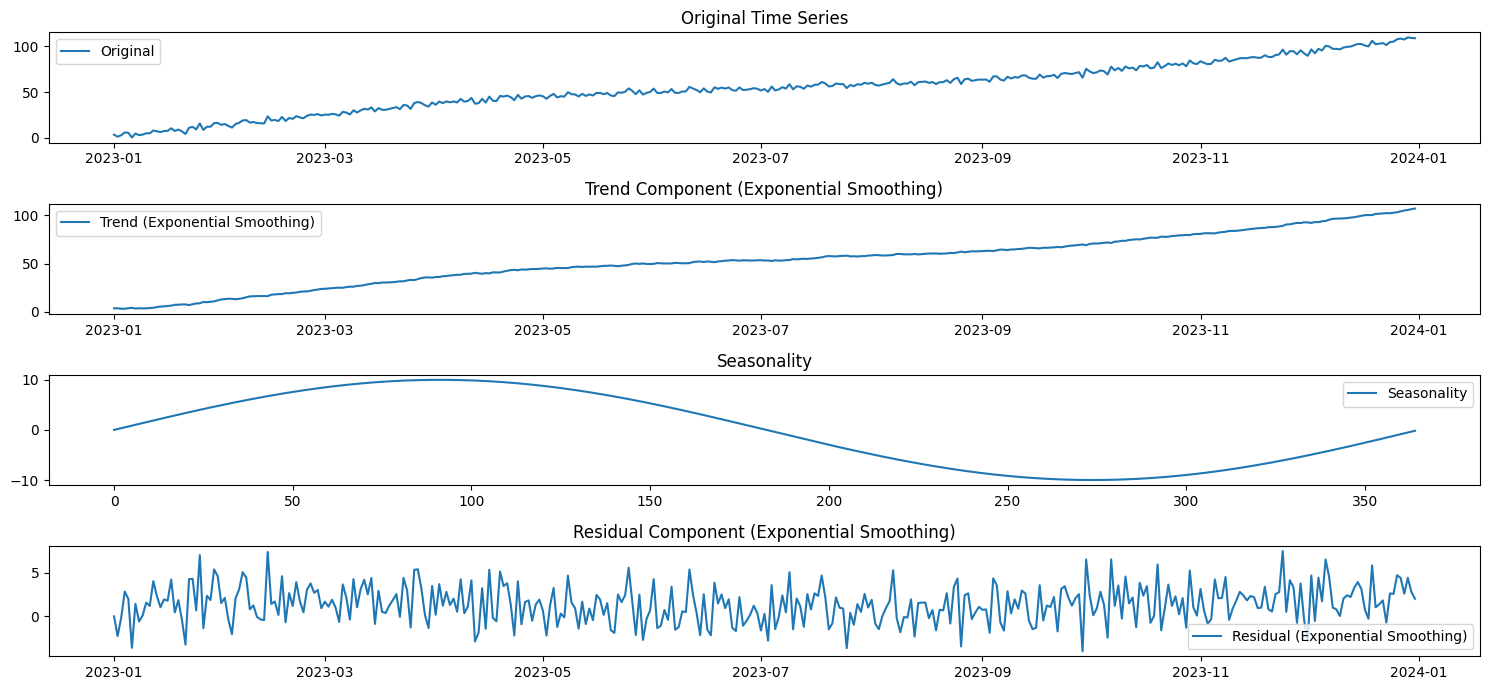

In [5]:
# additive decompsition with exponential smoothing
model = SimpleExpSmoothing(ts)
fitted_model = model.fit(
    smoothing_level = 0.2, optimized=False
)
trend_exp_smooth = fitted_model.fittedvalues
residual_exp_smooth = ts - trend_exp_smooth

# plotting
plt.figure(figsize=(15, 7))
plt.subplot(4, 1, 1)
plt.plot(ts, label='Original')
plt.title('Original Time Series')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(trend_exp_smooth, label='Trend (Exponential Smoothing)')
plt.title('Trend Component (Exponential Smoothing)')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(seasonality, label='Seasonality')
plt.title('Seasonality')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(residual_exp_smooth, label='Residual (Exponential Smoothing)')
plt.title('Residual Component (Exponential Smoothing)')
plt.legend()

plt.tight_layout()
plt.show()

### Comparison of MA and Exp Smoothing

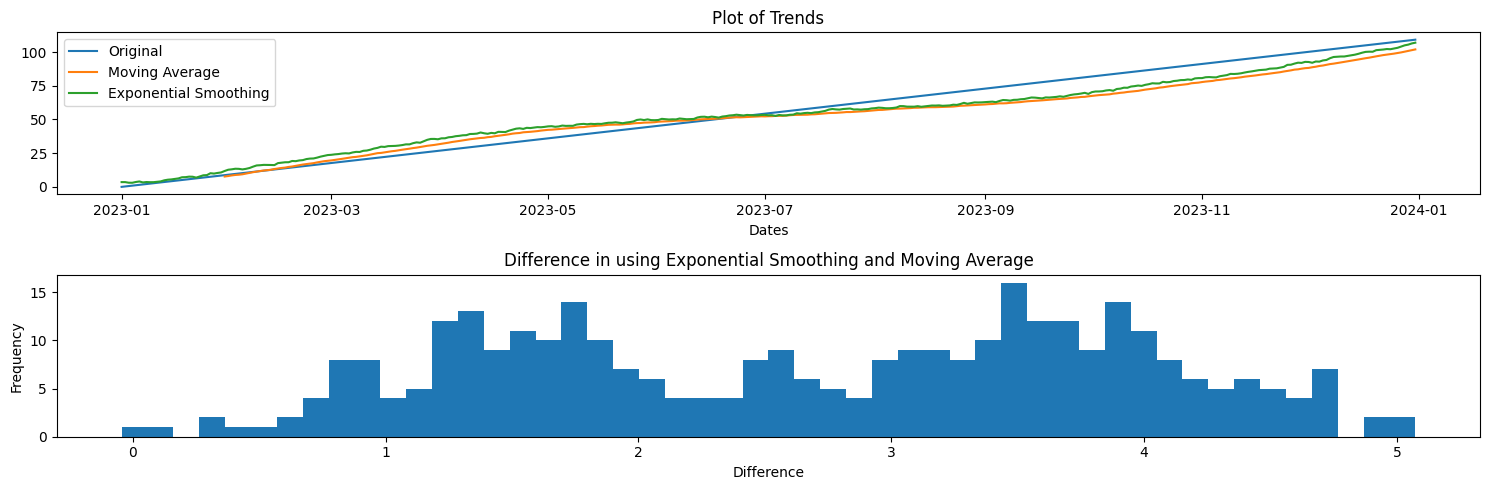

In [6]:
# plotting
plt.figure(figsize=(15, 5))

plt.subplot(2, 1, 1)
plt.plot(trend_sma.index, trend, label='Original')
plt.plot(trend_sma, label='Moving Average')
plt.plot(trend_exp_smooth, label='Exponential Smoothing')
plt.xlabel('Dates')
plt.title('Plot of Trends')
plt.legend()

plt.subplot(2, 1, 2)
plt.hist(
    trend_exp_smooth - trend_sma, 
    bins=50
)
plt.title(
    f'Difference in using Exponential Smoothing and Moving Average'
)
plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

Exponential seems to have more variance

## Multiplicative Decomposition

Multiplicative decomposition
- breaks a time series into fixed trend, seasonal, and residual components
- it assumes multiplicative seasonal patterns and is suitable for time series data where the magnitude of the seasonal fluctuations varies in proportion to the level of the series.
- $Y = T(t)S(t)\epsilon(t)$

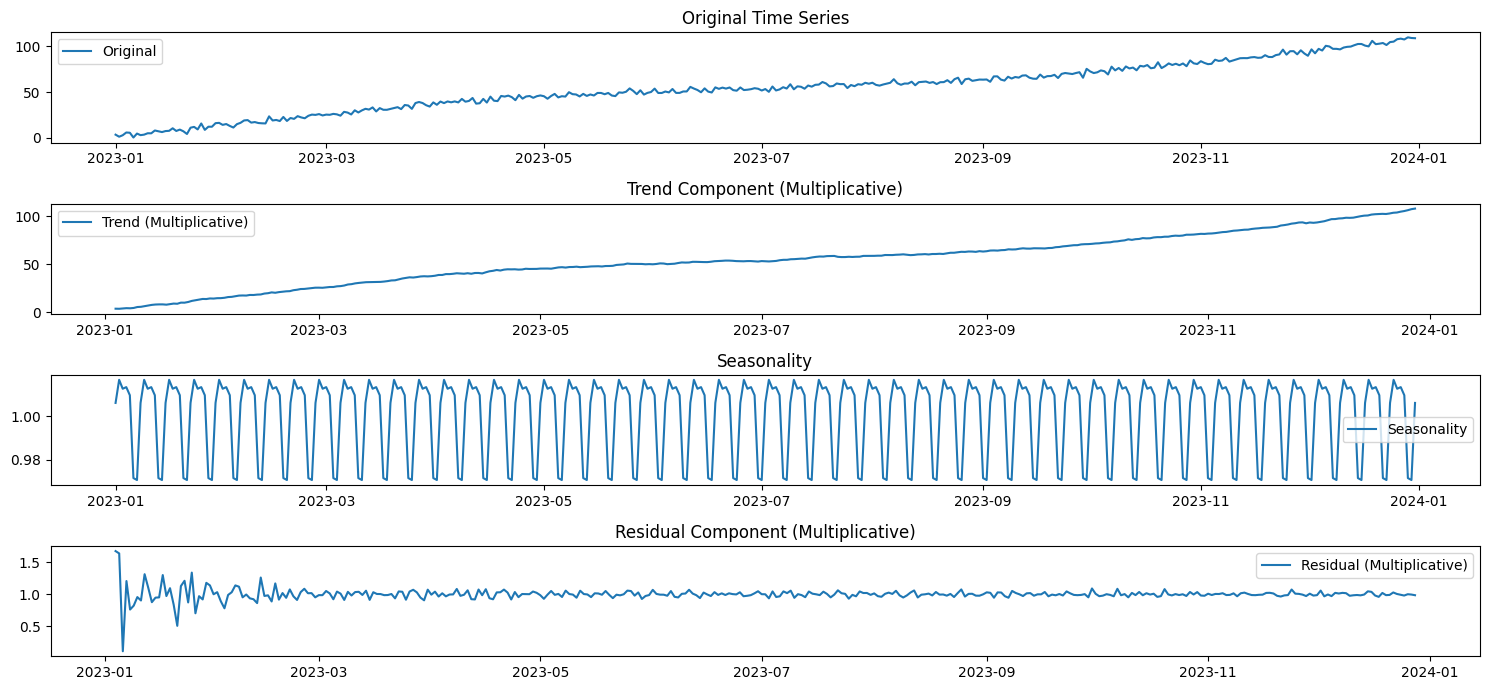

In [8]:
# multiplicative decomposition
result = seasonal_decompose(ts, model='multiplicative')

# components
trend_mul = result.trend.dropna()
seasonal_mul = result.seasonal.dropna()
residual_mul = result.resid.dropna()

# plotting
plt.figure(figsize=(15, 7))
plt.subplot(4, 1, 1)
plt.plot(ts, label='Original')
plt.title('Original Time Series')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(trend_mul, label='Trend (Multiplicative)')
plt.title('Trend Component (Multiplicative)')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(seasonal_mul, label='Seasonality')
plt.title('Seasonality')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(residual_mul, label='Residual (Multiplicative)')
plt.title('Residual Component (Multiplicative)')
plt.legend()

plt.tight_layout()
plt.show()

## Learnings

1. `scipy.signal` does not have morlet anymore. use `pywavelets` instead.
2. I'm surprised moving average and exponential smoothing seem to not differ that much.

## References

In this notebook, I referred to the following:
1. Learning general time series decomposition
    - [Medium article for TSD](https://medium.com/@roshmitadey/time-series-decomposition-62cbf31ab65e)

2. Learning wavelet decomposition
    - [Medium article for wavelet decomposition](https://medium.com/pythoneers/wavelet-transform-a-practical-approach-to-time-frequency-analysis-662bdadeb08b)
    - [Pywavelet CWT](https://pywavelets.readthedocs.io/en/latest/ref/cwt.html)
4. Learning singular spectrum analysis
    - [decomposition methods](https://medium.com/@datasciencewizards/preprocessing-and-data-exploration-for-time-series-decomposing-time-series-a44e074c5847)